In [2]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



In [3]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile as tiff
import seaborn as sns
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
from skimage import measure
from scipy.ndimage import center_of_mass
from glob import glob
import random
from skimage.measure import regionprops, label
from scipy.spatial import distance

import imageio.v2 as imageio
from tifffile import imread


import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [10]:
# # === Setup directories ===
# mask_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # <-- Update this if your mask directory is located elsewhere
# output_base_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video"
# output_frames_dir = os.path.join(output_base_dir, "frames")
# os.makedirs(output_frames_dir, exist_ok=True)



# def analyze_mask_from_path(mask_path, frame):
#     def plot_labels(original, ax, title=None,
#                     txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
#                               'fontsize': 'x-large', 'fontweight': 'bold'},
#                     cmap='gist_earth'):
#         ax.imshow(original, cmap=cmap)
#         labels = np.unique(original)
#         print("Labels in plot_labels function:", labels)
#         ax.set_title(title)
#         for label in labels:
#             if label != 0:
#                 inds = np.argwhere(original == label)
#                 loc = inds.mean(0)
#                 ax.text(loc[1], loc[0], str(label), **txt_args)

In [48]:
# === Setup directories ===
mask_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # <-- Update this if your mask directory is located elsewhere
output_base_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output"
output_frames_dir = os.path.join(output_base_dir, "frames")
os.makedirs(output_frames_dir, exist_ok=True)

# === Data structure to collect Frame -> Cell_IDs mapping ===
frame_cell_map = {}

# === Fixed plot size parameters ===
FIGSIZE = (8, 8)
DPI = 200  # Ensures consistent pixel size: 800x800 px

# === Main mask plotting function ===
def analyze_mask_from_path(mask_path, frame):
    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        labels = labels[labels != 0]  # Exclude background (label 0)
        print(f"Labels in plot_labels function (Frame {frame}):", labels)

        # Save labels per frame
        frame_cell_map[frame] = list(labels)

        ax.set_title(title)
        for label in labels:
            inds = np.argwhere(original == label)
            loc = inds.mean(0)
            ax.text(loc[1], loc[0], str(label), **txt_args)

    # Load and plot mask
    mask = imread(mask_path)
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    plot_labels(mask, ax, title=f"Frame {frame}")
    ax.axis('off')

    # Save figure at fixed size (no bbox cropping)
    output_path = os.path.join(output_frames_dir, f"frame_{frame:03d}.png")
    fig.savefig(output_path)
    plt.close()

# === Process all mask files ===
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
for idx, filename in enumerate(mask_files):
    mask_path = os.path.join(mask_dir, filename)
    analyze_mask_from_path(mask_path, idx)

# === Create video from frames — FIXED DIMENSIONS ===


video_output_path = os.path.join(output_base_dir, "mask_video_Label.mp4")
with imageio.get_writer(video_output_path, fps=1, format='ffmpeg') as video_writer:
    for idx in range(len(mask_files)):
        frame_path = os.path.join(output_frames_dir, f"frame_{idx:03d}.png")
        image = imageio.imread(frame_path)
        video_writer.append_data(image)

# === Save compact CSV with Frame and Cell IDs ===
frame_cell_list = []
for frame, cell_ids in frame_cell_map.items():
    cell_ids_str = ",".join(str(cid) for cid in cell_ids)
    frame_cell_list.append({"Frame": frame, "Cell_IDs": cell_ids_str})

frame_cell_df = pd.DataFrame(frame_cell_list)
frame_cell_csv_path = os.path.join(output_base_dir, "Frame_cell_list_Label.csv")
frame_cell_df.to_csv(frame_cell_csv_path, index=False)

# Output paths
video_output_path, frame_cell_csv_path


Labels in plot_labels function (Frame 0): [ 1  2  3  4  5  6  7  8  9 10 11 12]
Labels in plot_labels function (Frame 1): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 2): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 3): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 4): [ 2  3  4  5  6  7  8  9 10 11 12 14 22]
Labels in plot_labels function (Frame 5): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 6): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 7): [ 2  3  4  5  6  7  8  9 10 11 12 14]
Labels in plot_labels function (Frame 8): [ 2  3  4  5  6  7  8  9 10 11 12]
Labels in plot_labels function (Frame 9): [ 2  3  4  5  6  7  8  9 10 11 12]
Labels in plot_labels function (Frame 10): [ 2  3  4  5  6  7  8  9 10 11 12]
Labels in plot_labels function (Frame 11): [ 2  3  4  5  6  7  8  9 10 11 12 27]
Labels in plot_labels function (Frame 12): [

[rawvideo @ 0x12808080] Stream #0: not enough frames to estimate rate; consider increasing probesize


('/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output/mask_video_Label.mp4',
 '/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output/Frame_cell_list_Label.csv')

# Old Code Data Frame

Found 100 mask files.


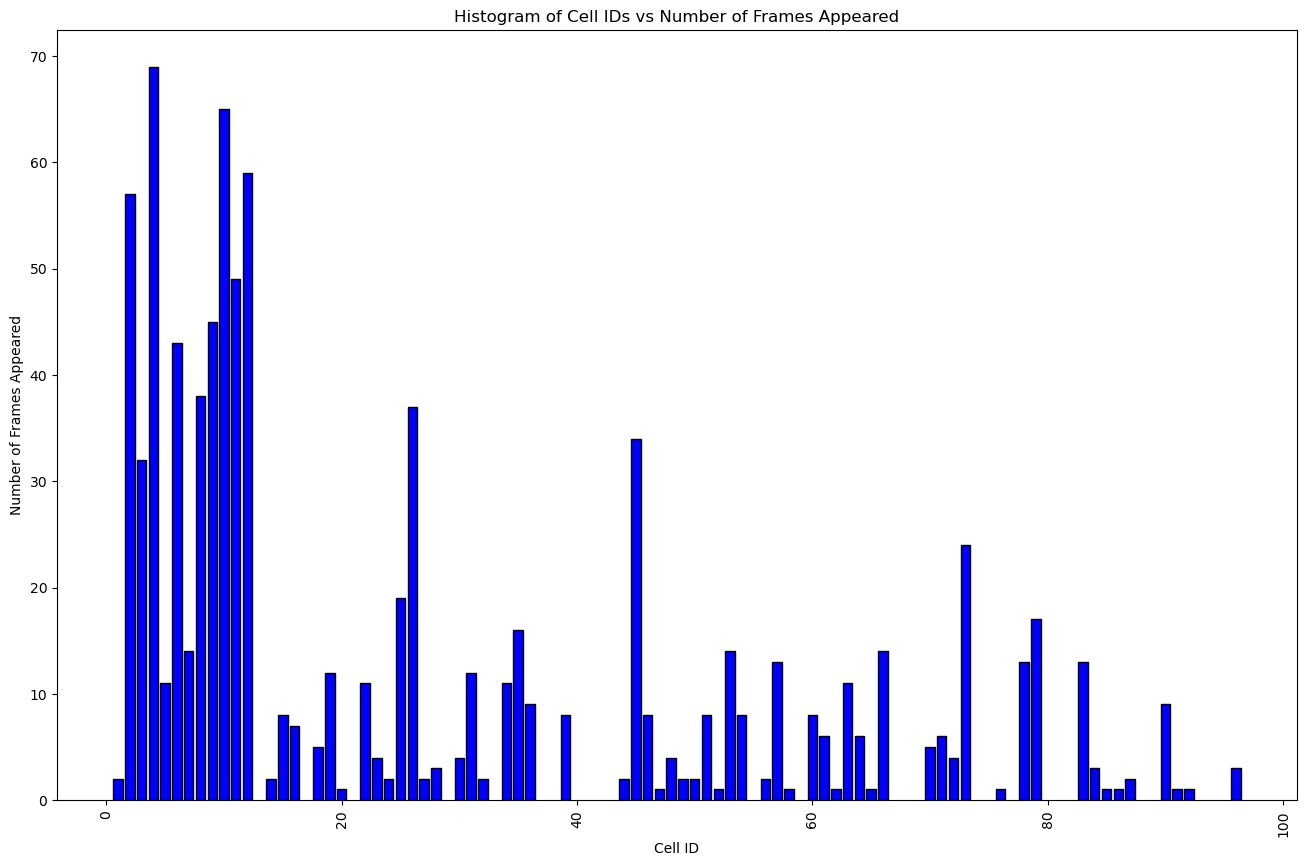

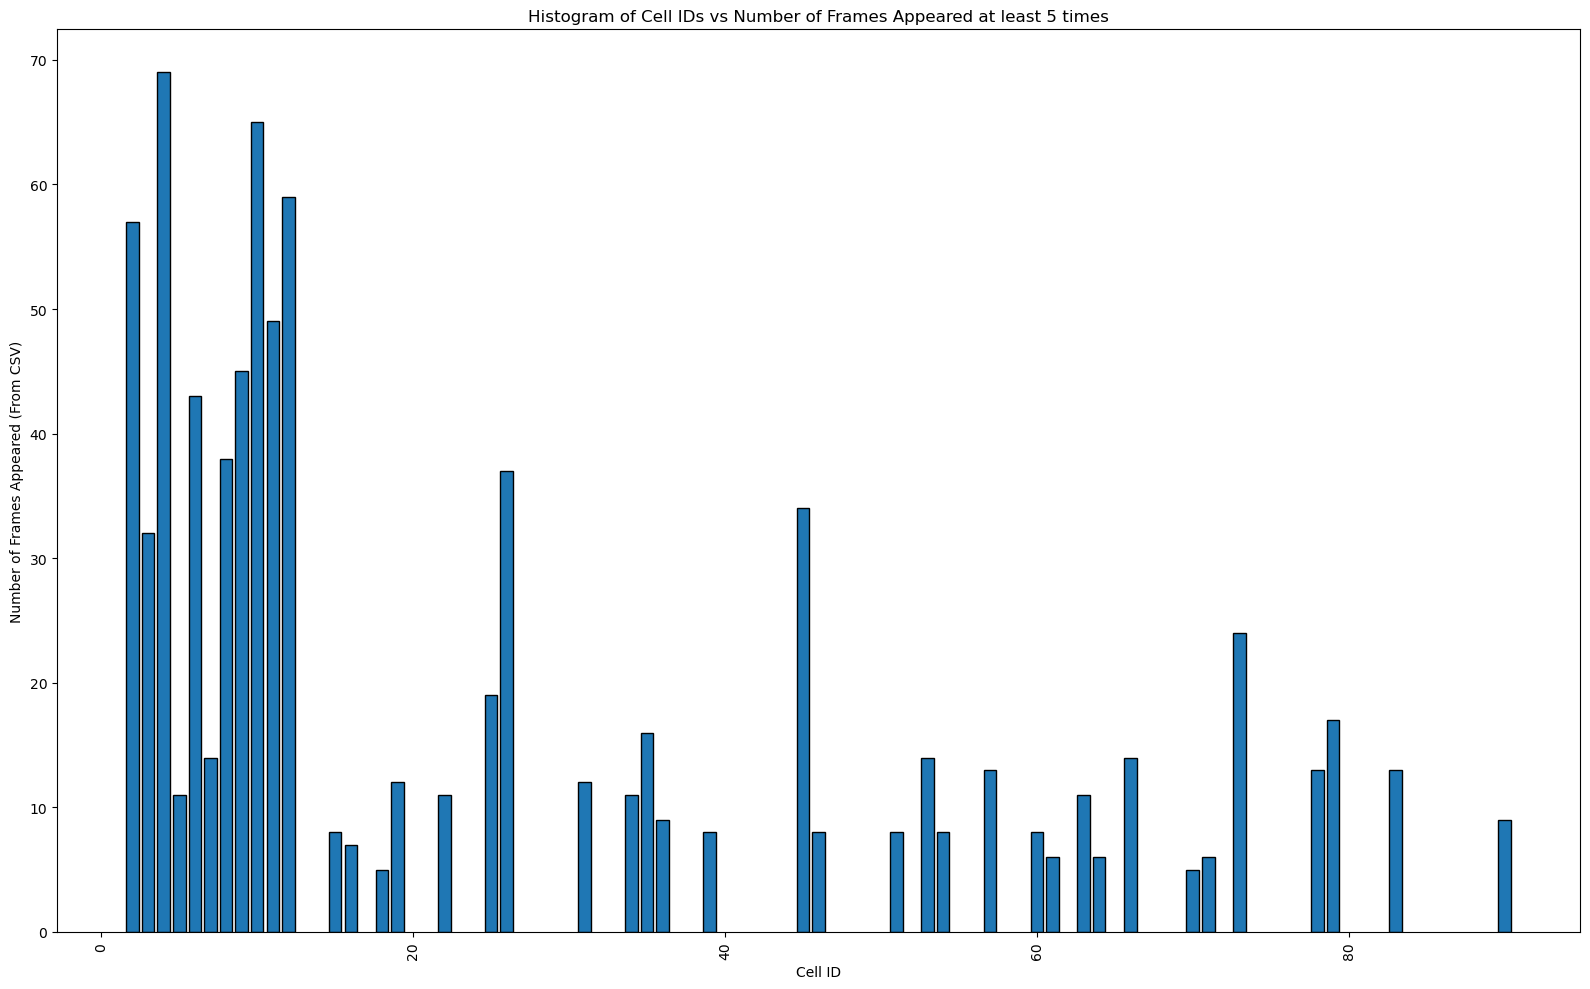

    Cell Number                                    Frames Appeared
0             2  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...
1             3  [1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, 36,...
2             4  [2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, 24,...
3             5            [2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7   [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
6             8  [1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55, 5...
7             9  [3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,...
8            10  [3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 22...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11           15                    [9, 27, 44, 49, 55, 56, 67, 68]
12           16                         [5, 9, 11, 38, 64, 65, 66]
13           18                                [2, 19, 20, 23,

In [12]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, window_size=5):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    
    os.makedirs(output_directory, exist_ok=True)
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # window_size=5


    # os.makedirs(output_directory, exist_ok=True)
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)
    
    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # calculate the frame list
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"), index=False)
    # Separate Chunk for Moving Average Calculation
    moving_average_variables = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    # window_size = 5

    for var in moving_average_variables:
        df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
    df.to_csv(ma_csv_path, index=False)


    # frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
    plt.show()


    # Additional Bar Plot from "Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"
    frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv")
    if os.path.exists(frame_list_csv_path):
        frame_list_df = pd.read_csv(frame_list_csv_path)
        frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

        plt.figure(figsize=(16, 10))
        plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
        plt.xlabel("Cell ID")
        plt.ylabel("Number of Frames Appeared (From CSV)")
        plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
        plt.show()
    else:
        print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")





    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    
    return df





    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    
    # print(frame_list)
    # print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    # return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


In [13]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, window_size=5):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
      
    
    os.makedirs(output_directory, exist_ok=True)
   
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)
    
       
    return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))




# # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
# df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

Found 100 mask files.
    Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0             1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1             2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
2             3      0  34402.0  1078.517857  0.844615  0.557695     0.371654   
3             4      0  30846.0  1245.813275  0.652812  0.449126     0.249748   
4             5      0  20008.0  1260.475180  0.756303  0.551367     0.158250   
5             6      0  29621.0  1139.879292  0.738623  0.487588     0.286478   
6             7      0  25385.0   969.293506  0.811930  0.549816     0.339529   
7             8      0  56570.0  1752.097546  0.790084  0.664154     0.231568   
8             9      0  42981.0  1612.003138  0.784583  0.550023     0.207852   
9            10      0  23447.0   890.801082  0.831424  0.550399     0.371309   
10           11      0  20281.0   701.889394  0.974720  0.754558     0.517323   
11    

# New Shape Measure
# Cell Id Match

In [15]:
# Re-import required modules after code execution environment reset


def analyze_cells_by_mask_labels_with_velocity(mask_directory, output_directory, size_threshold=1000):
    """Extract shape features and centroid velocities per cell per frame using original mask label as Cell_ID."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x)
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert and scale

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    previous_centroids = {}  # {Cell_ID: (x, y)}
    previous_frames = {}     # {Cell_ID: last_frame}

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping frame {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            cell_id = region.label  # Use original label as Cell_ID
            centroid_x, centroid_y = shape_factors[-2], shape_factors[-1]

            prev_x, prev_y = previous_centroids.get(cell_id, (None, None))
            prev_frame = previous_frames.get(cell_id, None)

            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid_x - prev_x
                y_centroid_distance = centroid_y - prev_y
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[cell_id] = (centroid_x, centroid_y)
            previous_frames[cell_id] = frame

            all_results.append([
                cell_id, frame
            ] + shape_factors + [
                x_centroid_distance, y_centroid_distance,
                x_centroid_velocity, y_centroid_velocity
            ])

    df = pd.DataFrame(all_results, columns=[
        "Cell_ID", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness",
        "Centroid_X", "Centroid_Y",
        "X_Centroid_Distance", "Y_Centroid_Distance",
        "X_Centroid_Velocity", "Y_Centroid_Velocity"
    ])

    os.makedirs(output_directory, exist_ok=True)
    final_csv_path = os.path.join(output_directory, "Cells_Shape_Features_By_Label_With_Velocity.csv")
    df.to_csv(final_csv_path, index=False)

    return df, final_csv_path



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/"

results_df, csv_path = analyze_cells_by_mask_labels_with_velocity(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))
print(f"CSV saved at: {csv_path}")



# Display message
print("Updated shape + velocity extraction function is ready. Provide your mask directory and output directory to run.")


Found 100 mask files.
    Cell_ID  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
0         1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1         2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
2         3      0  34402.0  1078.517857  0.844615  0.557695     0.371654   
3         4      0  30846.0  1245.813275  0.652812  0.449126     0.249748   
4         5      0  20008.0  1260.475180  0.756303  0.551367     0.158250   
5         6      0  29621.0  1139.879292  0.738623  0.487588     0.286478   
6         7      0  25385.0   969.293506  0.811930  0.549816     0.339529   
7         8      0  56570.0  1752.097546  0.790084  0.664154     0.231568   
8         9      0  42981.0  1612.003138  0.784583  0.550023     0.207852   
9        10      0  23447.0   890.801082  0.831424  0.550399     0.371309   
10       11      0  20281.0   701.889394  0.974720  0.754558     0.517323   
11       12      0  77284.0  3513.017423  0.575347  0.

# Cell Id Match
# Perfect Match

In [3]:
def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000):
    """Corrected: Extract shape features and centroid velocities per cell per frame using true mask label values (not region.label)."""
    

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

    all_results = []

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            coords = region.coords
            actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
            actual_labels = [val for val in actual_labels if val != 0]
            if not actual_labels:
                continue
            cell_id = actual_labels[0]  # Real label from mask, not from relabeling
            all_results.append([cell_id, frame] + shape_factors)

    df = pd.DataFrame(all_results, columns=[
        "Cell_ID", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
    ])

    df.sort_values(by=["Cell_ID", "Frame"], inplace=True)

    df["X_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_X"].diff().fillna(0)
    df["Y_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_Y"].diff().fillna(0)
    df["Frame_Diff"] = df.groupby("Cell_ID")["Frame"].diff().fillna(1)
    df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
    df.drop(columns="Frame_Diff", inplace=True)

    os.makedirs(output_directory, exist_ok=True)
    
    corrected_csv_path = os.path.join(output_directory, f"Cells_Shape_Features_TrueLabels_With_Velocity.csv")

    df.to_csv(corrected_csv_path, index=False)
    df.replace([np.inf, -np.inf], 0, inplace=True)


    return df, corrected_csv_path

print("✔ Corrected version: Uses actual mask label values instead of region.label — now fully aligned with frame_cell_list.csv")



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/"

results_df, csv_path = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(10))
print(f"CSV saved at: {csv_path}")



✔ Corrected version: Uses actual mask label values instead of region.label — now fully aligned with frame_cell_list.csv
     Cell_ID  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
0          1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1          2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
13         2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
26         2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
39         2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
52         2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
65         2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
78         2      6  19168.0   725.303607  0.834770  0.614359     0.457875   
89         2      7  19780.0   758.859956  0.806228  0.601801     0.431631   
101        2      8  20539.0   744.960461  0.815881  0.608960     0.465075   

     Convexity  Elong

In [ ]:
# # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
#     df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

#     frame_counts = df.groupby("Cell Number")["Frame"].nunique()
#     valid_cells = frame_counts[frame_counts >= 5].index
#     df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
#     frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
#     frame_list.columns = ["Cell Number", "Frames Appeared"]
    
#     os.makedirs(output_directory, exist_ok=True)
#     # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#     # window_size=5


#     # os.makedirs(output_directory, exist_ok=True)
#     # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#     original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_{window_size}.csv")
#     df.to_csv(original_csv_path, index=False)
    
#     # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
#     # calculate the frame list
#     frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"), index=False)
#     # Separate Chunk for Moving Average Calculation
#     moving_average_variables = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
#     # window_size = 5

#     for var in moving_average_variables:
#         df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

#     ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}.csv")
#     df.to_csv(ma_csv_path, index=False)


#     # frame_counts = df.groupby("Cell Number")["Frame"].nunique()
#     plt.figure(figsize=(16, 10))
#     plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
#     plt.xlabel("Cell ID")
#     plt.ylabel("Number of Frames Appeared")
#     plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
#     plt.xticks(rotation=90)
#     plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
#     plt.show()


#     # Additional Bar Plot from "Cells_Frames_List_HP4_Sign_AL_{window_size}.csv"
#     frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL_{window_size}.csv")
#     if os.path.exists(frame_list_csv_path):
#         frame_list_df = pd.read_csv(frame_list_csv_path)
#         frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

#         plt.figure(figsize=(16, 10))
#         plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
#         plt.xlabel("Cell ID")
#         plt.ylabel("Number of Frames Appeared (From CSV)")
#         plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
#         plt.xticks(rotation=90)
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
#         plt.show()
#     else:
#         print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")





#     print(frame_list)
#     print(f"Original results saved at: {original_csv_path}")
#     print(f"Results with moving averages saved at: {ma_csv_path}")
#     print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    
#     return df





In [ ]:
# def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000):
#     """Corrected: Extract shape features and centroid velocities per cell per frame using true mask label values (not region.label)."""
    

#     def calculate_shape_factors(region):
#         area = region.area
#         perimeter = region.perimeter
#         convex_area = region.convex_area
#         bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

#         solidity = area / convex_area if convex_area > 0 else 0
#         extent = area / bounding_box_area if bounding_box_area > 0 else 0
#         circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

#         convex_mask = region.convex_image.astype(np.uint8) * 255
#         contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
#         convexity = convex_perimeter / perimeter if perimeter > 0 else 0

#         min_diameter = region.minor_axis_length
#         max_diameter = region.major_axis_length
#         elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
#         compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

#         centroid = region.centroid
#         cx, cy = centroid[1] * 0.68, centroid[0] * 0.68

#         return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

#     if not os.path.exists(mask_directory):
#         raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

#     mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
#     if not mask_files:
#         raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

#     all_results = []

#     for mask_path in mask_files:
#         frame_str = os.path.splitext(os.path.basename(mask_path))[0]
#         frame_match = re.search(r'\d+', frame_str)
#         frame = int(frame_match.group()) if frame_match else None
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

#         if mask is None:
#             continue

#         labeled_mask = label(mask)
#         properties = regionprops(labeled_mask)

#         filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

#         for region in filtered_regions:
#             shape_factors = calculate_shape_factors(region)
#             coords = region.coords
#             actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
#             actual_labels = [val for val in actual_labels if val != 0]
#             if not actual_labels:
#                 continue
#             cell_id = actual_labels[0]  # Real label from mask, not from relabeling
#             all_results.append([cell_id, frame] + shape_factors)

#     df = pd.DataFrame(all_results, columns=[
#         "Cell_ID", "Frame", "Area", "Perimeter", "Solidity", "Extent",
#         "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
#     ])

#     df.sort_values(by=["Cell_ID", "Frame"], inplace=True)

#     df["X_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_X"].diff().fillna(0)
#     df["Y_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_Y"].diff().fillna(0)
#     df["Frame_Diff"] = df.groupby("Cell_ID")["Frame"].diff().fillna(1)
#     df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
#     df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
#     df.drop(columns="Frame_Diff", inplace=True)

#     os.makedirs(output_directory, exist_ok=True)
    
#     corrected_csv_path = os.path.join(output_directory, f"Cells_Shape_Features_TrueLabels_With_Velocity.csv")

#     df.to_csv(corrected_csv_path, index=False)
#     df.replace([np.inf, -np.inf], 0, inplace=True)


#     return df, corrected_csv_path

# print("✔ Corrected version: Uses actual mask label values instead of region.label — now fully aligned with frame_cell_list.csv")



# #######  Example usage
# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/"

# results_df, csv_path = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)

# # Display the first few rows of the resulting DataFrame
# print(results_df.head(10))
# print(f"CSV saved at: {csv_path}")



# Cell Id Match
# Perfect Match
# Moving Average

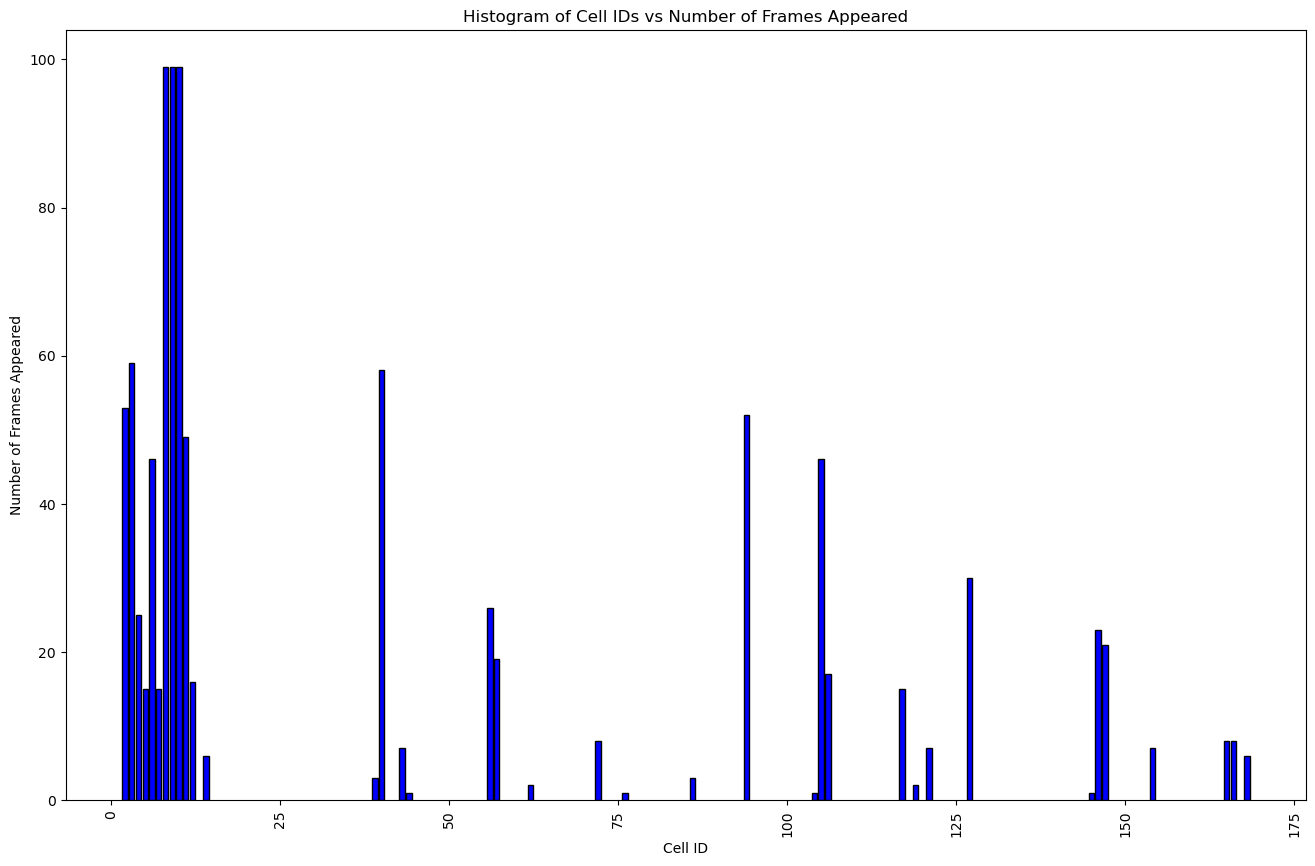

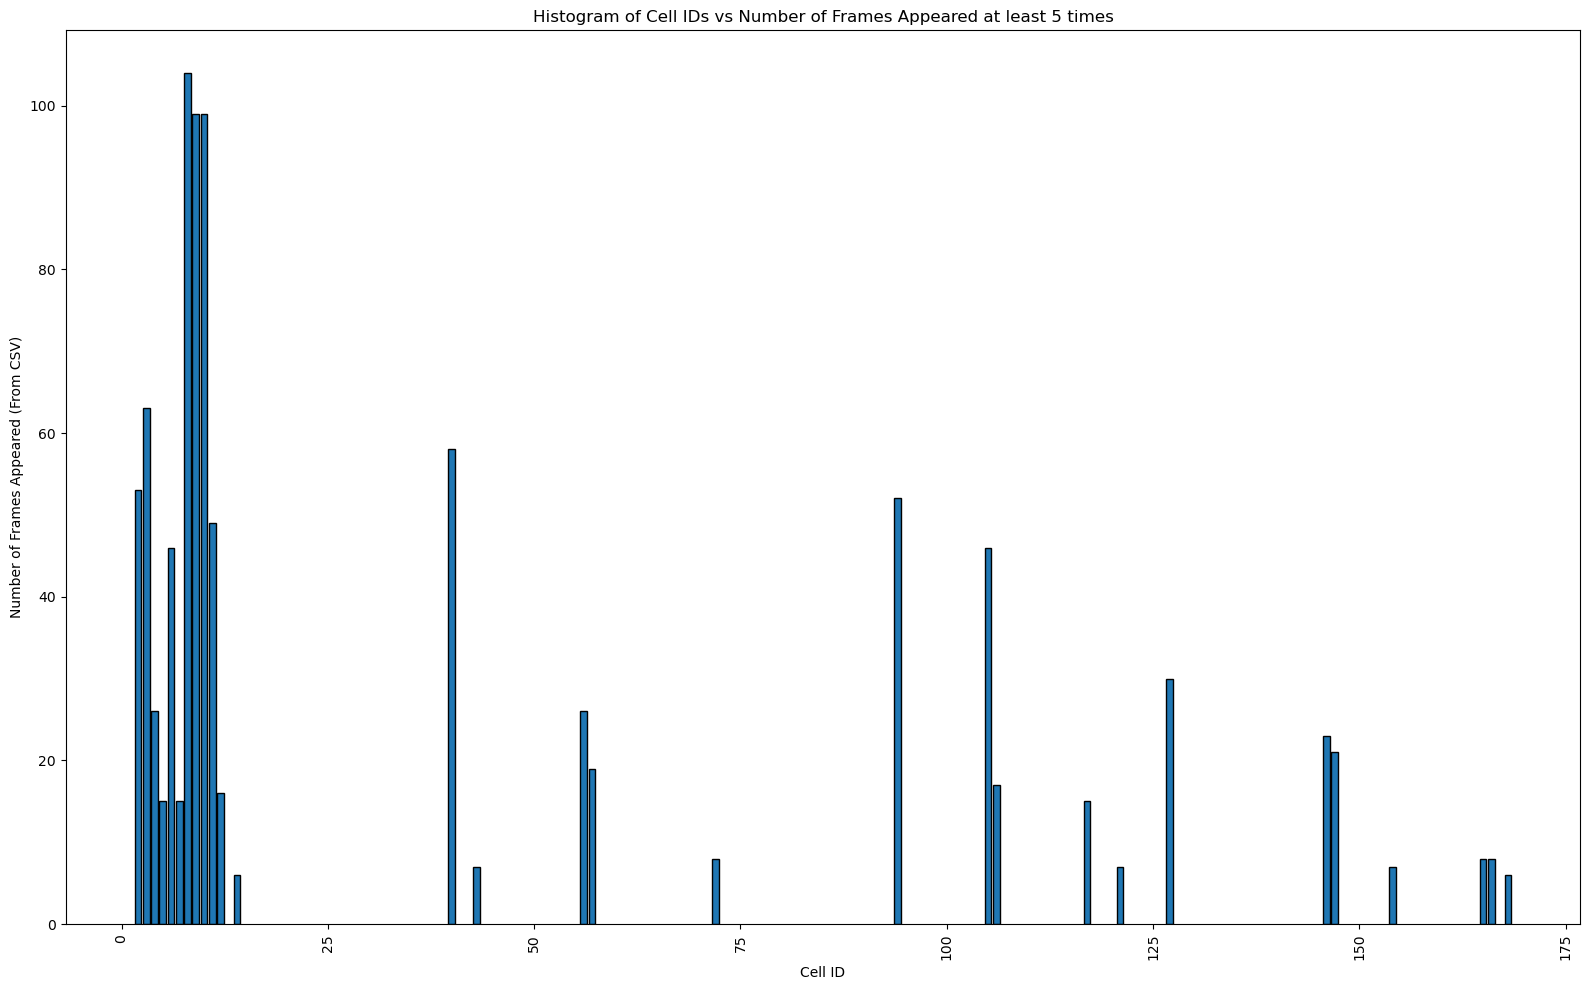

    Cell Number                                    Frames Appeared
0             2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1             3  [1, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...
2             4  [1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3             5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
6             8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7             9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
8            10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11           14                                 [2, 3, 4, 5, 6, 7]
12           40  [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...
13           43                       [20, 21, 22, 23, 24, 25,

In [49]:


def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000, window_size=5):
    """Corrected & Enhanced: Extracts true-label shape features, centroid velocities, moving averages, and visualizations."""

    start_time = time.time()

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

    all_results = []

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            coords = region.coords
            actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
            actual_labels = [val for val in actual_labels if val != 0]
            if not actual_labels:
                continue
            cell_id = actual_labels[0]
            all_results.append([cell_id, frame] + shape_factors)

    df = pd.DataFrame(all_results, columns=[
        "Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
    ])

    df.sort_values(by=["Cell Number", "Frame"], inplace=True)

    # Calculate velocities
    df["X_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_X"].diff().fillna(0)
    df["Y_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_Y"].diff().fillna(0)
    df["Frame_Diff"] = df.groupby("Cell Number")["Frame"].diff().fillna(1)
    df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
    df.drop(columns="Frame_Diff", inplace=True)

    # Remove velocity=0 rows
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    # Filter cells with at least 5 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    # Frame list generation
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]

    os.makedirs(output_directory, exist_ok=True)

    # Save original CSV
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)

    # Save frame list
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_{window_size}.csv"), index=False)

    # Moving average computation
    moving_average_variables = [
        "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation",
        "Circularity", "Convexity", "Centroid_X", "Centroid_Y",
        "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"
    ]

    for var in moving_average_variables:
        df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    # Save MA CSV
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_{window_size}.csv")
    df.to_csv(ma_csv_path, index=False)

    # Histogram plot
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
    plt.show()

    # Additional Bar Plot from frame_list CSV
    frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_{window_size}.csv")
    if os.path.exists(frame_list_csv_path):
        frame_list_df = pd.read_csv(frame_list_csv_path)
        frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

        plt.figure(figsize=(16, 10))
        plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
        plt.xlabel("Cell ID")
        plt.ylabel("Number of Frames Appeared (From CSV)")
        plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
        plt.show()
    else:
        print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")

    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")

    return df



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output"

results_df = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


# Original VS Moving Average of Cells_Centroid_Velocity plot for a particular cell

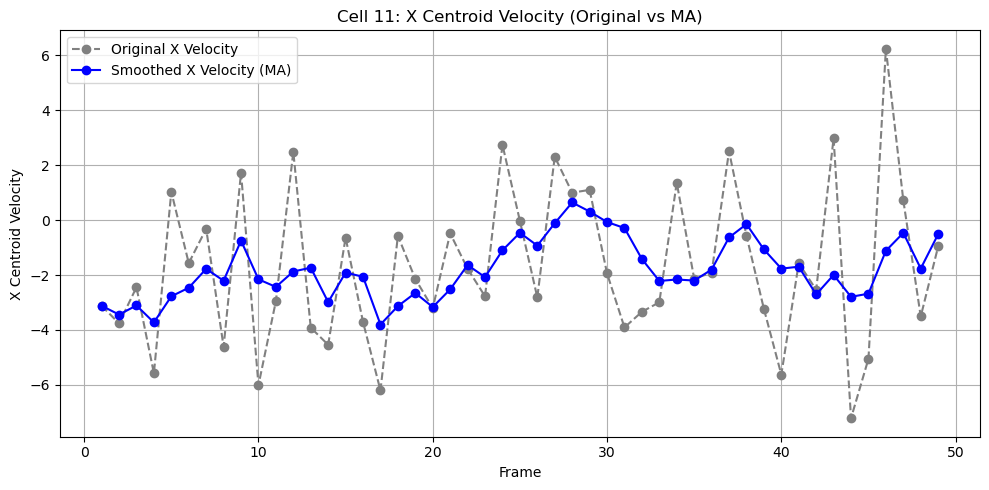

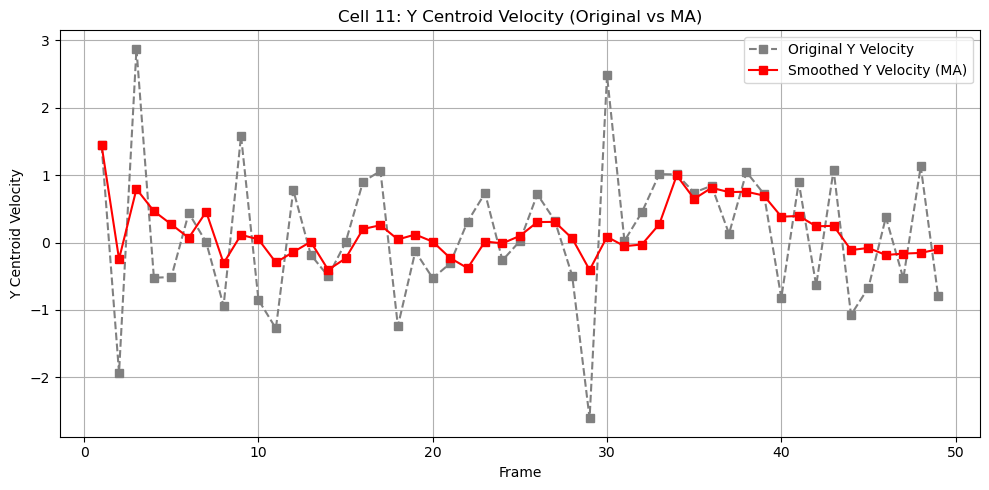

In [57]:
def plot_cell_velocity_comparison(input_directory,output_directory, cell_id, window_size):
    # File paths
    ma_csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_{window_size}.csv")
    original_csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_{window_size}.csv")

    # Check if files exist
    if not os.path.exists(ma_csv_path) or not os.path.exists(original_csv_path):
        print(f"Error: Required CSV files not found in {input_directory}")
        return

    # Load data
    df_ma = pd.read_csv(ma_csv_path)
    df_orig = pd.read_csv(original_csv_path)

    # Filter by Cell ID
    cell_ma = df_ma[df_ma["Cell Number"] == cell_id]
    cell_orig = df_orig[df_orig["Cell Number"] == cell_id]

    if cell_ma.empty or cell_orig.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    # Sort frames just in case
    cell_ma = cell_ma.sort_values(by="Frame")
    cell_orig = cell_orig.sort_values(by="Frame")

    # Plot X Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["X_Centroid_Velocity"], marker='o', linestyle='--', color='gray', label='Original X Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='blue', label='Smoothed X Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity")
    plt.title(f"Cell {cell_id}: X Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS X_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()

    # Plot Y Centroid Velocity
    plt.figure(figsize=(10, 5))
    plt.plot(cell_orig["Frame"], cell_orig["Y_Centroid_Velocity"], marker='s', linestyle='--', color='gray', label='Original Y Velocity')
    plt.plot(cell_ma["Frame"], cell_ma["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='red', label='Smoothed Y Velocity (MA)')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity")
    plt.title(f"Cell {cell_id}: Y Centroid Velocity (Original vs MA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"Line_Plot_Frame VS Y_Centroid_Velocity_MA{window_size}_{cell_id}.png"))
    plt.show()


# Example Usage
# plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2, window_size=5)
cell_id=11
window_size=5
input_directory="/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output"
output_directory="/home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape"
plot_cell_velocity_comparison(input_directory,output_directory, cell_id, window_size)




# Plot a Single Mask Frame with Labels

Labels in plot_labels function: [  0   8   9  10  40  94 105 117 127]


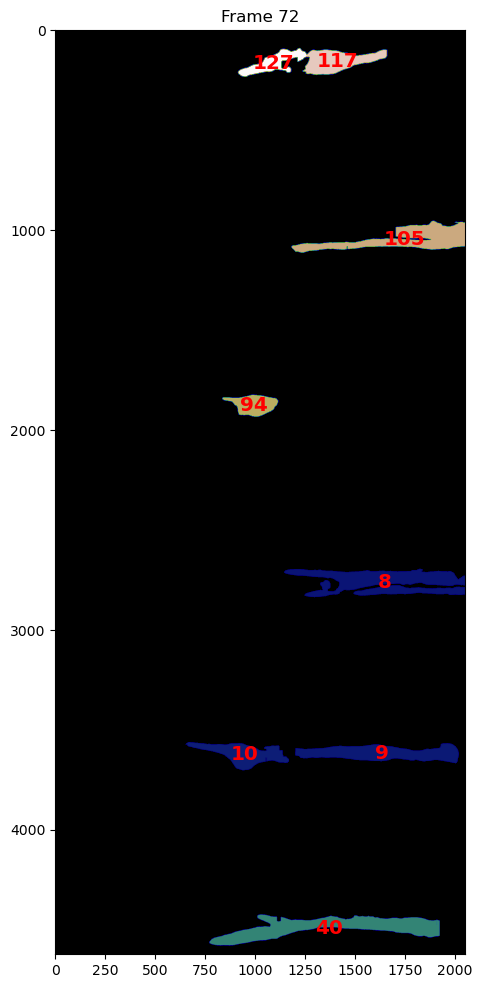

✅ Frame 72 plotted and saved to /home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output/frames/frame_072_labeled.png


In [55]:


# === Setup directories ===
mask_dir = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"  # <-- Change if needed
output_base_dir = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output"
output_frames_dir = os.path.join(output_base_dir, "frames")
os.makedirs(output_frames_dir, exist_ok=True)

def analyze_mask_from_path(mask_path, frame_num):
    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise ValueError(f"Could not read mask file: {mask_path}")

    fig, ax = plt.subplots(figsize=(12, 12))
    plot_labels(mask, ax, title=f"Frame {frame_num}")
    frame_output_path = os.path.join(output_frames_dir, f"frame_{frame_num:03d}_labeled.png")
    # plt.savefig(frame_output_path)
    # plt.close()
    plt.show()
    print(f"✅ Frame {frame_num} plotted and saved to {frame_output_path}")

# === Example: Plot a specific frame ===
frame_to_plot = 72  # ← Change this to the frame number you want
frame_filename = f"mask{frame_to_plot:04d}.tif"  # Example: '001.tif'
frame_path = os.path.join(mask_dir, frame_filename)

analyze_mask_from_path(frame_path, frame_to_plot)


# 2-D PCA and Cluster Analysis, Box-Plot by Clusters

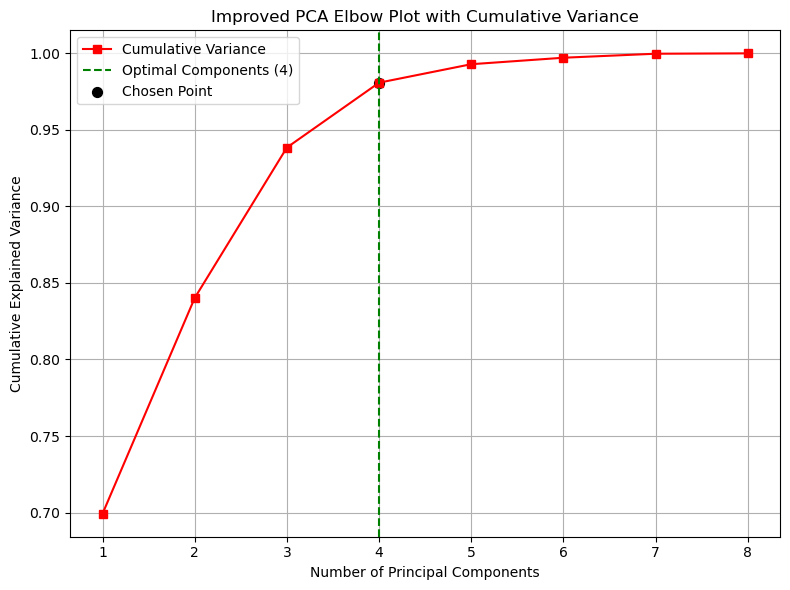

Optimal number of PCA components selected: 4


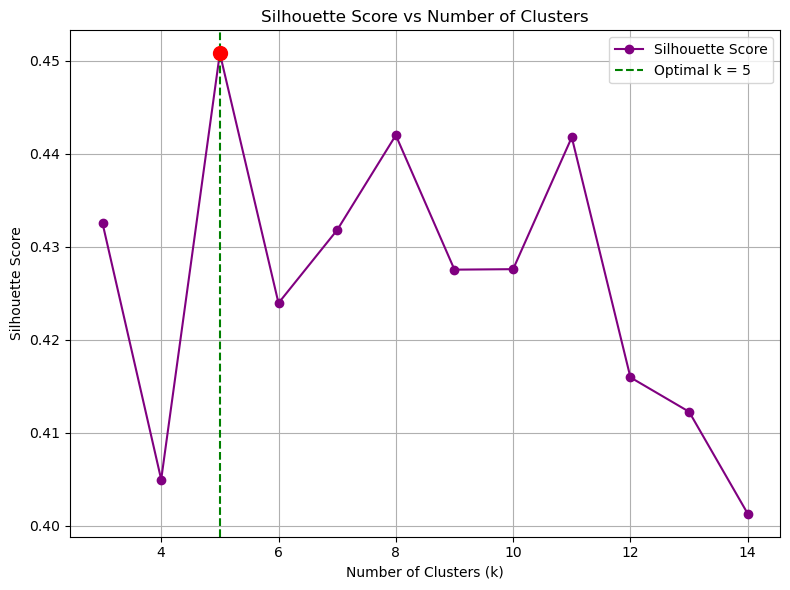

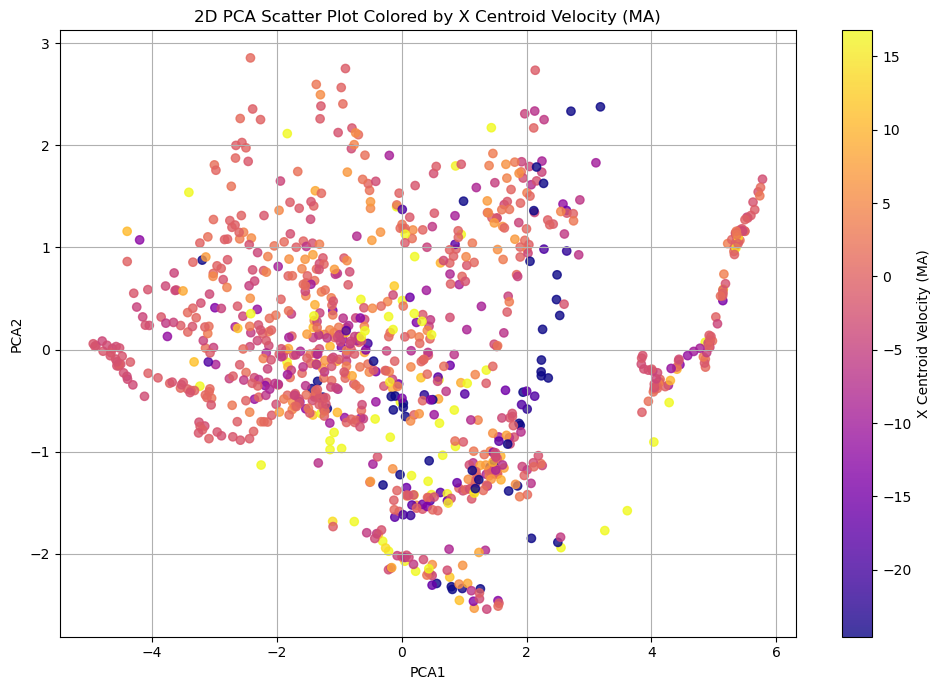

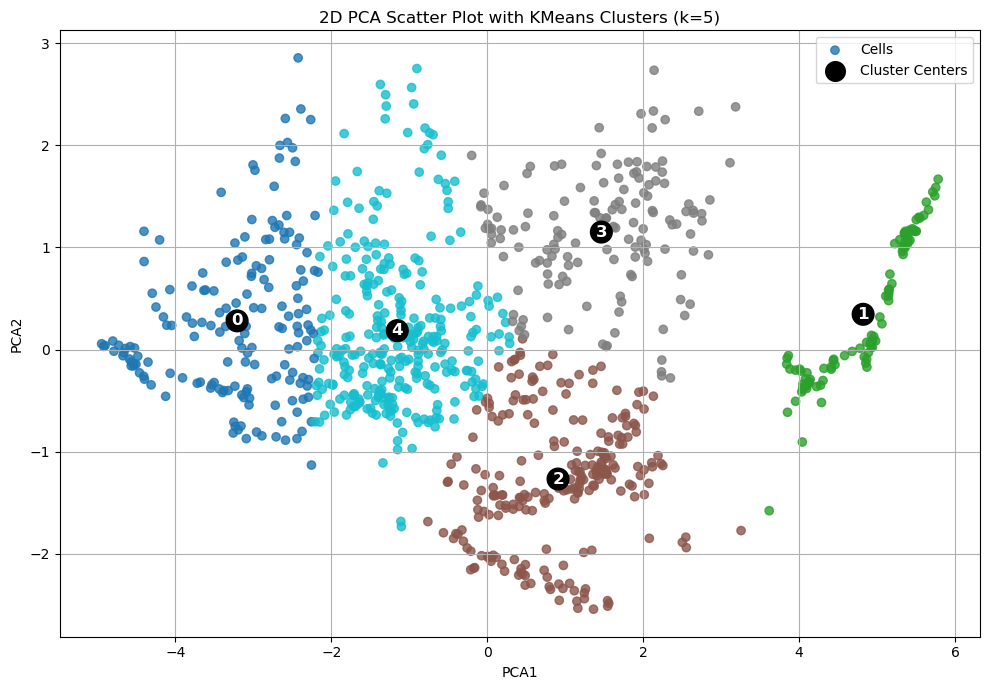

✅ PCA complete. Explained variance: [0.69925122 0.14093352 0.09827735 0.04237227 0.01206898]...
✅ Optimal K for clustering: 5
📁 Results saved: /home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape/PCA_Cluster_Results_5.csv
📊 Cluster summary saved: /home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape/PCA_Cluster_Summary_5.csv


/tmp/ipykernel_1704210/1882192267.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")


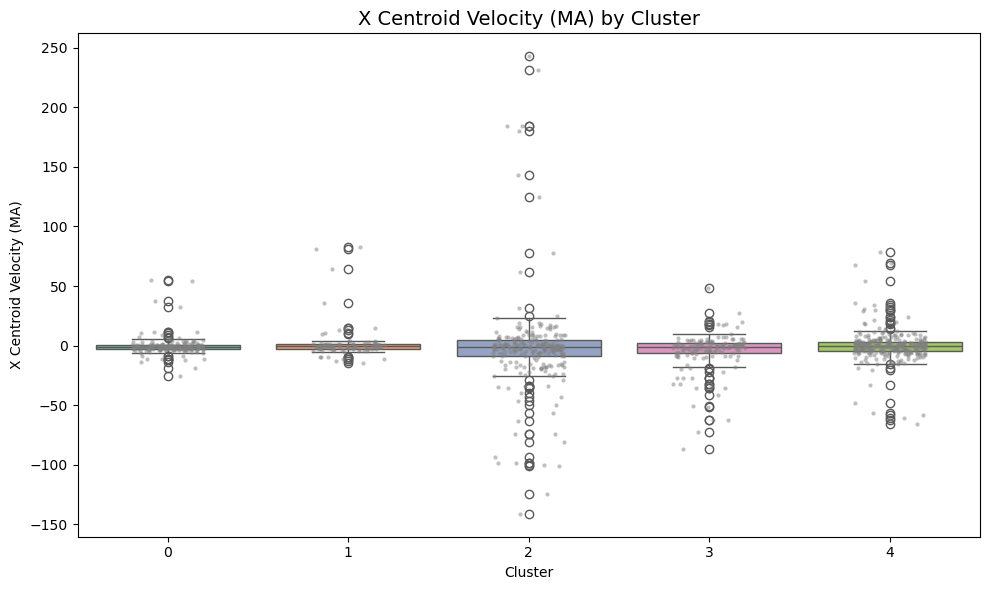

In [72]:


def apply_pca_with_clustering(csv_path, output_directory, window_size):
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", 
                        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
    
    mini_df = df[selected_columns].copy()

    # Standardize features (excluding Cell Number and velocity)
    features_to_scale = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"])
    X_scaled = StandardScaler().fit_transform(features_to_scale)

    # --- PCA Variance Analysis and Elbow Plot ---
    pca_full = PCA()
    pca_full.fit(X_scaled)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # --- Apply 2D PCA ---
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["Cell Number"] = mini_df["Cell Number"]
    pca_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]

    # --- KMeans Clustering in 2D PCA Space ---
    silhouette_scores = []
    k_range = range(3, 15)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(pca_df[["PCA1", "PCA2"]])
        score = silhouette_score(pca_df[["PCA1", "PCA2"]], kmeans.labels_)
        silhouette_scores.append(score)

    # Plot silhouette scores vs k with annotation
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    # plt.annotate(f"Best k = {optimal_k}\nScore = {optimal_score:.2f}",
    #              xy=(optimal_k, optimal_score),
    #              xytext=(optimal_k + 0.3, optimal_score - 0.05),
    #              arrowprops=dict(facecolor='black', arrowstyle="->"),
    #              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs Number of Clusters")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"Silhouette_Score_vs_K_{window_size}.png"))
    plt.show()

    # --- Final Clustering ---
    kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init='auto')
    pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PCA1", "PCA2"]])
    cluster_centers = kmeans.cluster_centers_

    # --- Save PCA+Cluster Results ---
    output_csv = os.path.join(output_directory, f"PCA_Cluster_Results_{window_size}.csv")
    pca_df.to_csv(output_csv, index=False)

    # --- Plot 2D PCA colored by X Centroid Velocity ---
    vmin = np.percentile(pca_df["X_Centroid_Velocity_MA"], 5)
    vmax = np.percentile(pca_df["X_Centroid_Velocity_MA"], 95)

    plt.figure(figsize=(10, 7))
    sc = plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["X_Centroid_Velocity_MA"], cmap="plasma", alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, label="X Centroid Velocity (MA)")
    plt.title("2D PCA Scatter Plot Colored by X Centroid Velocity (MA)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_2D_XVelocity_{window_size}.png"))
    plt.show()

    # --- Plot 2D PCA colored by Cluster with Cluster Centers ---
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["Cluster"], cmap="tab10", alpha=0.8, label='Cells')

    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, marker='o', label='Cluster Centers')
    for idx, (x, y) in enumerate(cluster_centers):
        plt.text(x, y, f"{idx}", fontsize=12, fontweight='bold', ha='center', va='center', color='white',
                 bbox=dict(facecolor='black', boxstyle='circle,pad=0.2'))

    plt.title(f"2D PCA Scatter Plot with KMeans Clusters (k={optimal_k})")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PCA_2D_Clusters_{window_size}.png"))
    plt.show()

    # --- Cluster Summary Statistics ---
    cluster_summary = pca_df.groupby("Cluster").agg({
        "PCA1": ["mean", "std"],
        "PCA2": ["mean", "std"],
        "X_Centroid_Velocity_MA": ["mean", "std"],
    }).reset_index()
    cluster_summary.columns = ["_".join(col).strip("_") for col in cluster_summary.columns.values]

    summary_path = os.path.join(output_directory, f"PCA_Cluster_Summary_{window_size}.csv")
    cluster_summary.to_csv(summary_path, index=False)

    print(f"✅ PCA complete. Explained variance: {explained_variance[:5]}...")
    print(f"✅ Optimal K for clustering: {optimal_k}")
    print(f"📁 Results saved: {output_csv}")
    print(f"📊 Cluster summary saved: {summary_path}")

    

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pca_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")
    sns.stripplot(data=pca_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)
    plt.title("X Centroid Velocity (MA) by Cluster", fontsize=14)
    plt.xlabel("Cluster")
    plt.ylabel("X Centroid Velocity (MA)")
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"Seaborn_Boxplot_XVelocity_By_Cluster_{window_size}.png"))
    plt.show()


    # # --- Compute Cluster-Wise Feature Means (for Clustermap) ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # # --- Seaborn Clustermap of Cluster-wise Feature Means ---
    # clustermap_data = cluster_feature_means.copy()

    # sns.clustermap(clustermap_data, cmap="vlag", annot=True, fmt=".2f", linewidths=0.5,
    #                figsize=(12, 8), col_cluster=True, row_cluster=True, cbar_kws={"label": "Feature Mean"})
    # plt.suptitle(f"Clustermap: Cluster-wise Feature Profiles (k={optimal_k})", fontsize=14)
    # plt.subplots_adjust(top=0.93)

    # clustermap_path = os.path.join(output_directory, f"Cluster_Feature_Clustermap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(clustermap_path)
    # plt.show()

    # print(f"🧬 Cluster feature clustermap saved: {clustermap_path}")



    # # --- Heatmap of Feature Means per Cluster ---
    # feature_df = mini_df.drop(columns=["Cell Number"]).copy()
    # feature_df["Cluster"] = pca_df["Cluster"].values  # align clusters
    # cluster_feature_means = feature_df.groupby("Cluster").mean()

    # plt.figure(figsize=(12, 6))
    # sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Feature Mean"})
    # plt.title(f"Cluster-wise Mean of Morphological and Velocity Features (k={optimal_k})")
    # plt.tight_layout()
    # heatmap_path = os.path.join(output_directory, f"Cluster_Feature_Mean_Heatmap_K{optimal_k}_{window_size}.png")
    # # plt.savefig(heatmap_path)
    # plt.show()

    # print(f"🧠 Feature mean heatmap saved: {heatmap_path}")






# Run it
window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape"
input_directory= "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output"
csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_{window_size}.csv")
apply_pca_with_clustering(csv_path, output_directory, window_size)


# Phate Analysis

Optimal PCA components to retain 95% variance: 4
PCA Variance Explained with 4 components: 0.9808
Calculating PHATE...
  Running PHATE on 949 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.41 seconds.
Calculated PHATE in 0.67 seconds.


<Figure size 700x500 with 0 Axes>

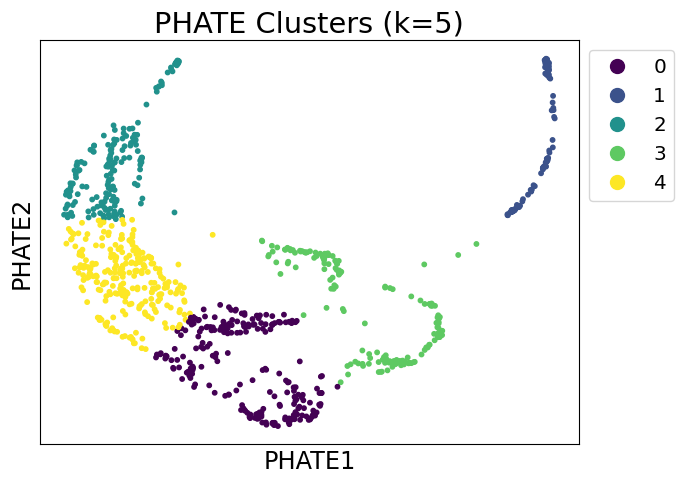

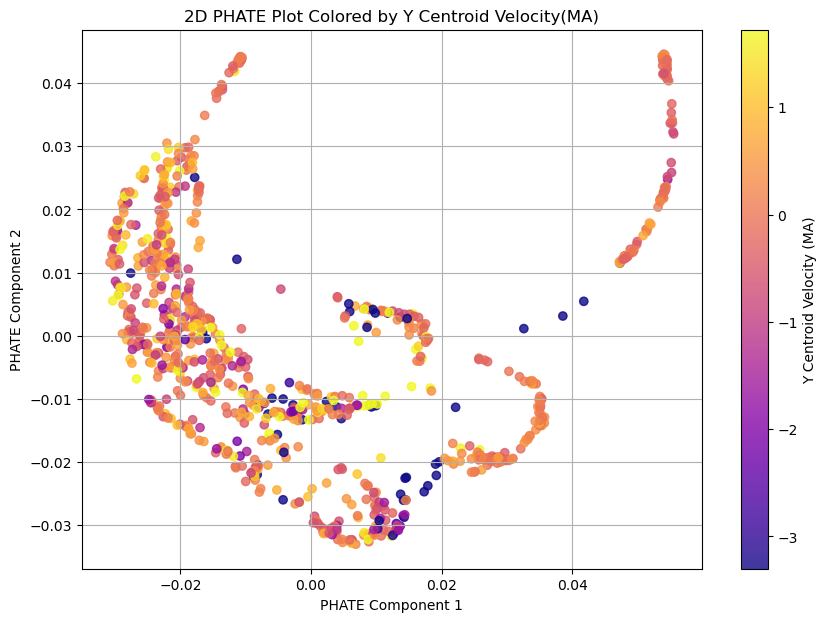

     PHATE1    PHATE2  Cell Number  Y_Centroid_Velocity_MA  Cluster
0 -0.025639  0.024982            2                1.202573        2
1 -0.025531  0.024920            2               -0.238771        2
2 -0.028229  0.020914            2                0.973764        2
3 -0.030023  0.016794            2                1.582531        2
4 -0.029258  0.018149            2               -0.062263        2
5 -0.029913  0.016634            2                0.266741        2
6 -0.030205  0.013509            2                0.374851        2
7 -0.029853  0.015827            2               -0.042072        2
8 -0.029522  0.012056            2               -0.359565        2
9 -0.028777  0.004947            2                0.562658        4


In [4]:


def apply_phate(csv_path,output_directory,window_size, variance_threshold=0.95, k_clusters=5):
    """Load CSV, apply PCA for variance retention, use PHATE for 2D visualization, and apply k-means clustering."""
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Select relevant numeric features
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
   
    
    mini_df = df[selected_columns].copy()    
    
    # Drop 'Cell Number' for feature scaling
    feature_cols = mini_df.drop(columns=["Cell Number","X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()
    
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components dynamically
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Convert to DataFrame
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]

    # phate_df["Convexity_MA"] = mini_df["Convexity_MA"]
    phate_df["Y_Centroid_Velocity_MA"] = mini_df["Y_Centroid_Velocity_MA"]
    # phate_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]

    # Apply k-means clustering on PHATE embedding
    kmeans = KMeans(n_clusters=k_clusters, random_state=44)
    clusters = kmeans.fit_predict(X_phate)
    phate_df["Cluster"] = clusters

    #2D PHATE Scatter Plot Colored by Clusters
    # cmap=sns.husl_palette(k_clusters)
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap= "viridis", s=10,
        figsize=(7,5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1,1), fontsize=12, title=f'PHATE Clusters (k={k_clusters})'
    )
    plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
    plt.show()

    # 2D PHATE Scatter Plot Colored by X_Centroid_Velocity #cmap='coolwarm'

   
    # plt.figure(figsize=(10, 7))
    # sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Convexity_MA"], cmap='viridis', alpha=0.8)
    # plt.colorbar(sc, label="Convexity (MA)")
    # plt.title("2D PHATE Plot Colored by Convexity (MA)")
    # plt.xlabel("PHATE Component 1")
    # plt.ylabel("PHATE Component 2")
    # plt.grid(True)
    # plt.savefig(os.path.join(output_directory,f"PHATE Plot Colored by Convexity_MA_{window_size}.png"))
    # plt.show()

    # ✅ 2D PHATE Scatter Plot Colored by X Centroid Velocity with clipped scale
    vmin = np.percentile(phate_df["Y_Centroid_Velocity_MA"], 5)
    vmax = np.percentile(phate_df["Y_Centroid_Velocity_MA"], 95)

    # vmin = np.percentile(phate_df["Convexity_MA"], 5)
    # vmax = np.percentile(phate_df["Convexity_MA"], 95)

    plt.figure(figsize=(10, 7))
    sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
                         c=phate_df["Y_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8,vmin=vmin, vmax=vmax)
    
    # sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
    #                      c=phate_df["Convexity_MA"], cmap='plasma', alpha=0.8,vmin=vmin, vmax=vmax)
    

    plt.colorbar(sc_vel, label="Y Centroid Velocity (MA)")
    plt.title("2D PHATE Plot Colored by Y Centroid Velocity (MA)")

    # plt.colorbar(sc_vel, label="Convexity (MA)")
    # plt.title("2D PHATE Plot Colored by Convexity (MA)")
    # plt.xlabel("PHATE Component 1")
    # plt.ylabel("PHATE Component 2")
    # plt.grid(True)
    # plt.savefig(os.path.join(output_directory, f"PHATE Plot Colored by Convexity_MA_{window_size}.png"))
    # plt.show()


    # 2D PHATE Scatter Plot Colored by Y_Centroid_Velocity
    # plt.figure(figsize=(10, 7))
    # sc_y = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Y_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8)
    # plt.colorbar(sc_y, label="Y Centroid Velocity(MA)")
    plt.title("2D PHATE Plot Colored by Y Centroid Velocity(MA)")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    # plt.savefig(os.path.join(output_directory, f"PHATE Plot Colored by Y-Centroid_Velocity_{window_size}.png"))
    plt.show()

    return phate_df




# # "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"
window_size=5
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape/"
input_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output/"
csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_{window_size}.csv")
phate_results = apply_phate(csv_path, output_directory,window_size)

# Display the first few rows
print(phate_results.head(10))


In [ ]:


def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95):
    """Apply PCA + PHATE + dynamic KMeans clustering with optimal k selection using silhouette scores."""

    # Load data
    df = pd.read_csv(csv_path)

    # Select relevant columns
    selected_columns = [
        "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
        "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
    ]
    mini_df = df[selected_columns].copy()

    # Drop 'Cell Number' and velocities for PCA features
    feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Determine optimal k using silhouette score
    silhouette_scores = []
    k_range = range(3, 15)
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=44, n_init='auto').fit(X_phate)
        score = silhouette_score(X_phate, kmeans_temp.labels_)
        silhouette_scores.append(score)

    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)
    print(f"Optimal number of clusters based on silhouette score: k={optimal_k}, score={optimal_score:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs k (PHATE Space)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Silhouette_Scores_{window_size}.png"))
    plt.show()

    # Apply k-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=44, n_init='auto')
    clusters = kmeans.fit_predict(X_phate)

    # Save PHATE results
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    phate_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]
    phate_df["Cluster"] = clusters

    # Save to CSV
    phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_{window_size}.csv"), index=False)

    # Plot PHATE Clusters
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap="viridis", s=10,
        figsize=(7, 5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1, 1), fontsize=12, title=f'PHATE Clusters (k={optimal_k})'
    )
    # Plot cluster centroids
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=60, alpha=0.6, marker='X', label='Centroids')
    plt.legend()
    # plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_MA_{window_size}.png"))
    plt.show()

    # Plot PHATE colored by Y Centroid Velocity (with clipping)
    vmin = np.percentile(phate_df["X_Centroid_Velocity_MA"], 5)
    vmax = np.percentile(phate_df["X_Centroid_Velocity_MA"], 95)

    plt.figure(figsize=(10, 7))
    sc_vel = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"],
                         c=phate_df["X_Centroid_Velocity_MA"], cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc_vel, label="X Centroid Velocity (MA)")
    plt.title("2D PHATE Plot Colored by X Centroid Velocity (MA)")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    # plt.savefig(os.path.join(output_directory, f"PHATE_Centroid_Velocity_MA_{window_size}.png"))
    plt.show()

    return phate_df, optimal_k

# Optional: plot colored by feature
def color_by_feature(phate_df, feature, output_directory, window_size):
    vmin = np.percentile(phate_df[feature], 5)
    vmax = np.percentile(phate_df[feature], 95)
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df[feature],
                     cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, label=feature)
    plt.title(f"2D PHATE Plot Colored by {feature}")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, f"PHATE_Colored_by_{feature}_{window_size}.png"))
    plt.show()




window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/New_Shape/"
input_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Output/"
csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_{window_size}.csv")

phate_results, best_k = apply_phate(csv_path, output_directory, window_size)
print(phate_results.head(10))
print(f"Best cluster count (k): {best_k}")

# Optionally, color by another feature
color_by_feature(phate_results, "X_Centroid_Velocity_MA", output_directory, window_size)
